In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data as wb
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from matplotlib.pylab import rcParams
import time
rcParams['figure.figsize'] = 15, 6

In [2]:
#data = wb.DataReader('PETR4.SA', data_source='yahoo', start='2000-1-1')

In [3]:
#sheet = pd.read_excel('EMPRESAS_B3_09-07-21.xlsx', sheet_name='Página1')

In [4]:
sheet = pd.read_excel('LISTA_EMPRESAS_SELECIONADAS.xlsx', sheet_name='Planilha1')

In [5]:
list_df = []
list_error = []

In [6]:
tikers = sheet['Ticker']
len(tikers)

133

#### Coletando os dados na api

In [5]:
for tik in tikers:
    try:
        list_df.append(wb.get_data_yahoo(str(tik), start='2000-1-1', interval="m"))
        list_df[len(list_df)-1]['Ticker'] = tik
        if len(list_df[-1]) < 36:
            list_df.pop(-1)
        elif list_df[-1]['Volume'][-36:len(list_df[-1])-1].mean() < 20_000_000.00:
            list_df.pop(-1)
    except:
        list_error.append(tik)
        pass

In [90]:
#removendo valores zerados e ausentes
for i in range(0, len(list_df)):
    try:
        list_df[i].replace(0, np.nan, inplace=True)
        list_df[i] = list_df[i].dropna()
        list_df[i] = list_df[i].fillna(method='ffill')
    except:
        pass

In [7]:
#adicionando coluna de media
for i in range(0, len(list_df)):
    list_df[i]['Avg'] = ((list_df[i].loc[:, 'High']+list_df[i].loc[:, 'Low']) / 2.0)

In [8]:
#ordenando indices
for i in range(0, len(list_df)):
    list_df[i].sort_index()

In [9]:
df_concat = pd.DataFrame()
df_concat = list_df[0]

In [10]:
#exportando excel
for i in range(1, len(list_df)):
    df_concat = pd.concat([df_concat, list_df[i]])
df_concat.to_excel('dados_b3.xlsx')

### Importando dados do excel

In [14]:
dfExcel = pd.read_excel('dados_b3.xlsx', index_col='Date', parse_dates=['Date'])

In [44]:
df1 = dfExcel['Ticker'].unique()
df1[0]

'ABEV3.SA'

In [47]:
teste = dfExcel[(dfExcel['Ticker'] == df1[1])]
teste

,High,Low,Open,Close,Volume,Adj Close,Ticker,Avg
Date,,,,,,,,
2008-02-01,3.486100,3.035311,3.450037,3.149511,13296685,2.240382,ALPA4.SA,3.260705
2008-03-01,3.365890,2.976108,3.149511,3.215326,8332053,2.287200,ALPA4.SA,3.170999
2008-04-01,3.275732,2.886551,3.275732,3.035311,6139231,2.159148,ALPA4.SA,3.081141
2008-05-01,3.816679,3.035311,3.035311,3.771600,4455518,2.682901,ALPA4.SA,3.425995
2008-06-01,3.786626,2.945154,3.786626,3.005259,3560418,2.137770,ALPA4.SA,3.365890
...,...,...,...,...,...,...,...,...
2021-06-01,51.490002,46.369999,47.290001,50.189999,32037100,50.189999,ALPA4.SA,48.930000
2021-07-01,53.970001,49.349998,51.419998,51.459999,35701000,51.459999,ALPA4.SA,51.660000
2021-08-01,62.330002,52.299999,52.299999,59.970001,58686000,59.970001,ALPA4.SA,57.315001


### Etapas do processo
##### 1 - Função para devolver a serie com média móvel, função tem como parâmetro a serie e a janela 
##### 2 - Função para testar e transformar serie em estacionária, devolve uma ts estacionária
##### 3 - Aqui o bicho pega - identificar sazonalidade e tendência, qualificar isso
##### 4 - A partir dos dados qualificados, fazer previsão e testar sim ou não, parâmetro bool

In [9]:
def generete_ts_moving_avarege(ts : pd.Series, window : int):
    """Retorna uma serie temporal de média móvel com valores ausentes removidos"""
    ts = ts.rolling(window=window).mean()
    ts.dropna(inplace=True)
    return ts

In [20]:
def transform_stationary_ts(ts : pd.Series):
    """Recebe uma série temporal, testa e se preciso transforma e devolve uma serie estacionária. Retorna None em caso de falha"""
    adfuller_ts = adfuller(ts, autolag='AIC')
    if adfuller_ts[1] < 0.05:
        return ts
    else:
        ts_log1 = np.log(ts)
        adfuller_ts_log1 = adfuller(ts_log1, autolag='AIC')
        if adfuller_ts_log1[1] < 0.05:
            return ts_log1
        else:
            ts_log2 = np.log(ts_log1)
            adfuller_ts_log2 = adfuller(ts_log2, autolag='AIC')
            if adfuller_ts_log2[1] < 0.05:
                return ts_log2
            else:
                ts_log3 = np.log(ts_log2)
                adfuller_ts_log3 = adfuller(ts_log3, autolag='AIC')
                if adfuller_ts_log3[1] < 0.05:
                    return ts_log3
                else:
                    return

In [54]:
def components_seazonal_trend_resid_STL(ts : pd.Series):
    """Retorna uma tupla com os componentes isolados, sazonalidade, tendencia e residuo"""
    ts = ts.asfreq('MS')
    result = STL(ts, robust=True, period=12).fit()
    return (result.seazonal, result.trend, result.resid)

In [22]:
def seasonality_trend_rate(ts : tuple):
    """
    Recebe uma tupla com listas com os valores isolados de sazonalidade, tendencia e residuo, 
    e retorna um dict com a media da avaliação da força destes.
    """
    max_seazonal = (0.1 - (ts[2]/(ts[0] + ts[2])))
    max_seazonal.mean()
    max_trend = (0.1 - (ts[2]/(ts[1] + ts[2])))
    max_trend.mean()
    return {'max_seazonal': max_seazonal.mean(),
            'max_trend': max_trend.mean()}


In [48]:
def generete_avg_high_low_colunm(df : pd.DataFrame):
    for i in range(0, len(df)):
        df['Avg'] = ((df[i].loc[:, 'High']+df[i].loc[:, 'Low']) / 2.0)
    return df

In [106]:
def select_tickers_seazonals(df : pd.DataFrame):
    """
    Função responsável por selecionar os melhores ativos, a partir de critérios de
    força na sazonalidade e na tendência.
    """
    df_unique = df['Ticker'].unique()
    df_return = pd.DataFrame()
    list_rate = []
    list_tickers = []
    for i in df_unique:
        df_i = df[(df['Ticker'] == i)]
        #df_i = generete_avg_high_low_colunm(df_i)
        ts = generete_ts_moving_avarege(df_i['Avg'], 12)
        ts = transform_stationary_ts(ts)
        if ts is not None:
            components = components_seazonal_trend_resid_STL(ts)
            rate = seasonality_trend_rate(components)
            list_tickers.append(i)
            list_rate.append(rate)
        df_return['Ticker'] = list_tickers
        df_return['Rate'] = list_rate
    return df_return

In [107]:
df_new = select_tickers_seazonals(dfExcel)

C:\Users\Dagoberto Medeiros\anaconda3\envs\TCC\lib\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


MissingDataError: exog contains inf or nans

In [15]:
def adf_test(y):
  print('Resultado do teste de Dick-Fuller:')
  dftest = adfuller(y, autolag='AIC')
  dfoutput = pd.Series(dftest[0:4], index=['Teste', 'Valor P', '# de lags', '# de observações'])
  for key, value in dftest[4].items():
    dfoutput['Valor crítico({})'.format(key)] = value
  print(dfoutput)

In [16]:
adf_test(list_df[18]['Avg'])

Resultado do teste de Dick-Fuller:
Teste                -1.136178e+01
Valor P               9.434656e-21
# de lags             3.000000e+00
# de observações      2.310000e+02
Valor crítico(1%)    -3.458980e+00
Valor crítico(5%)    -2.874135e+00
Valor crítico(10%)   -2.573482e+00
dtype: float64


In [17]:
teste = adfuller(list_df[18]['Avg'], autolag='AIC')

In [18]:
teste[1]

9.434656191452139e-21

In [20]:
list_df[94].head(2)

,High,Low,Open,Close,Volume,Adj Close,Ticker,Avg
Date,,,,,,,,
2007-01-01,28.700001,22.60,23.00,28.4,9383600.0,22.765398,POSI3.SA,25.650001
2007-02-01,30.000000,25.01,28.41,26.0,4985600.0,20.841564,POSI3.SA,27.505000


In [22]:
y = list_df[94]['Avg']

In [28]:
adf_test(y)

Resultado do teste de Dick-Fuller:
Teste                  -2.660477
Valor P                 0.081131
# de lags              14.000000
# de observações      162.000000
Valor crítico(1%)      -3.471374
Valor crítico(5%)      -2.879552
Valor crítico(10%)     -2.576373
dtype: float64


In [26]:
rolmean = y.rolling(window=12).mean()
rolstd = y.rolling(window=12).std()

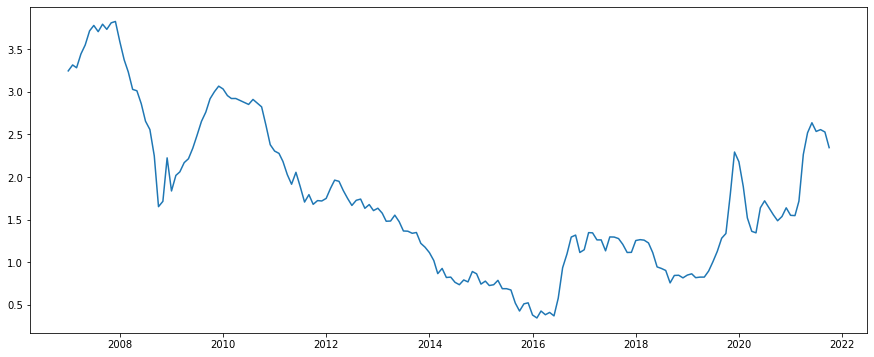

In [27]:
indexedDataSet_logScale = np.log(y)
plt.plot(indexedDataSet_logScale)

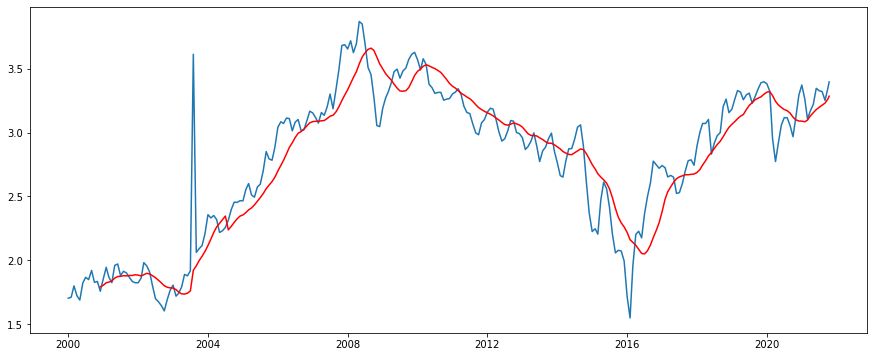

In [81]:
movingAverage = indexedDataSet_logScale.rolling(window=12).mean()
movingStd = indexedDataSet_logScale.rolling(window=12).std()
plt.plot(indexedDataSet_logScale)
plt.plot(movingAverage, color='red')

In [82]:
datasetLogScaleMinusMovingAverage = indexedDataSet_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head()

Date
2000-01-01   NaN
2000-02-01   NaN
2000-03-01   NaN
2000-04-01   NaN
2000-05-01   NaN
Name: Avg, dtype: float64

In [83]:
datasetLogScaleMinusMovingAverage.dropna(inplace=True) #remover os valores ausentes
datasetLogScaleMinusMovingAverage.head()

Date
2000-12-01   -0.034371
2001-01-01    0.049467
2001-02-01    0.120868
2001-03-01    0.037265
2001-04-01   -0.012773
Name: Avg, dtype: float64

In [84]:
adf_test(datasetLogScaleMinusMovingAverage)

Resultado do teste de Dick-Fuller:
Teste                -6.578347e+00
Valor P               7.624573e-09
# de lags             0.000000e+00
# de observações      2.510000e+02
Valor crítico(1%)    -3.456674e+00
Valor crítico(5%)    -2.873125e+00
Valor crítico(10%)   -2.572944e+00
dtype: float64


In [85]:
#list_df[0].head(2).round(2).sort_values(ascending=True, by='High' )

C:\Users\DAGOBE~1\AppData\Local\Temp/ipykernel_12172/2994331909.py:1: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(ts, freq=12, model='aditive')


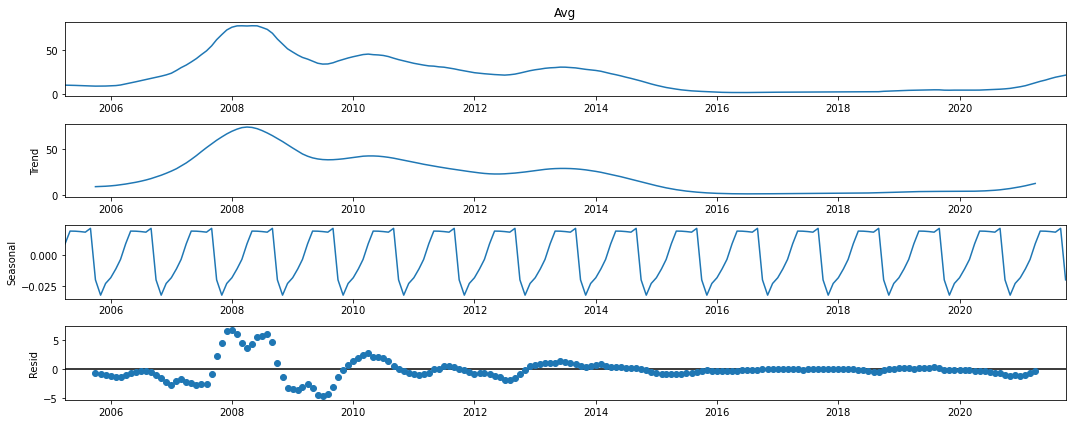

In [115]:
result = seasonal_decompose(ts, freq=12, model='aditive')
result.plot()
plt.show()

In [116]:
max_seazonal_cls = (0.1 - (result.resid/(result.seasonal + result.resid)))
max_seazonal_cls.mean()

-1.0553526284581036

In [123]:
max_trend_cls = (0.1 - (result.resid/(result.trend + result.resid)))
max_trend_cls.mean()

0.13160242055546248

In [117]:
dfSTL = ts

In [118]:
dfSTL = pd.DataFrame(dfSTL)
dfSTL.head()

,Avg
Date,
2005-04-01,9.830189
2005-05-01,9.733637
2005-06-01,9.543550
2005-07-01,9.374585
2005-08-01,9.148291


In [119]:
dfSTL.asfreq('MS')

,Avg
Date,
2005-04-01,9.830189
2005-05-01,9.733637
2005-06-01,9.543550
2005-07-01,9.374585
2005-08-01,9.148291
...,...
2021-06-01,15.604583
2021-07-01,17.296667
2021-08-01,18.901250


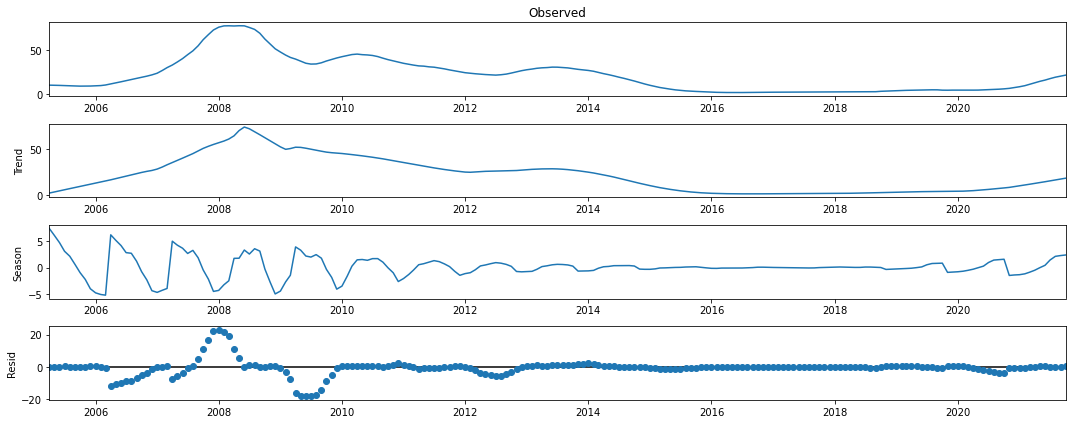

In [120]:
resultSTL = STL(dfSTL, robust=True, period=12).fit()
resultSTL.plot()
plt.show()

In [121]:
max_trend = (0.1 - (resultSTL.resid/(resultSTL.trend + resultSTL.resid)))
max_trend.mean()

0.20134184955049308

In [122]:
max_seazonal = (0.1 - (resultSTL.resid/(resultSTL.seasonal + resultSTL.resid)))
max_seazonal.mean()

-0.6157625266629536

In [49]:
resultSTL.trend.to_excel('resultSTL.xlsx', sheet_name='trend')

In [47]:
resultSTL.resid.to_excel('resultSTL.xlsx', sheet_name='resid')

In [48]:
resultSTL.observed.to_excel('resultSTL.xlsx', sheet_name='observed')

In [71]:
#result.seasonal.to_excel('resultClassic.xlsx')